# **Otimização - Toy Experiment: Mitigação de Crosstalk**
## **Notebook de Otimização**

**Disciplina:** PPGEE0016 - Otimização

**Alunos:** André Paiva, Josias Souza, Victor Emanuel Paz

In [396]:
import sys
sys.path.insert(1, "../crosstalk/")

from time import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from functions import *
from XTconstants import *

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [397]:
# Setting a random seed for reproducibility. Using a fixed seed value (5) ensures that the random numbers generated
# are the same across different runs of the code. This is important for verifying results, as it allows
# for consistent experimentation and comparison of outcomes.
#np.random.seed(5)

In [398]:
df = pd.read_csv("./dataset/data.csv", index_col=0)
df

,E,E_x,timescale_clean,timescale_xt,delay_sampling,tau,tau_x,sampling_period,S_1,S_2,S_3,S_4
0,59412.274869,4792.422617,0.833459,1.861120,3.271603,56.08,17.28,25,36628.139188,56017.230291,46173.096004,25153.393190
1,51691.298481,4170.764452,1.143950,1.382774,0.838006,40.86,23.26,25,42583.959191,46295.148692,19792.438474,1969.545282
2,79307.711870,2246.259140,1.356987,1.596575,0.570604,34.45,20.14,25,70982.377518,58703.986365,14629.961111,-6061.920666
3,52479.078704,4630.296477,0.880730,0.904404,4.445942,53.07,35.56,25,38643.639887,54477.231823,36248.645619,14829.577108
4,56096.098416,4498.329215,0.904736,1.683603,1.502552,51.67,19.10,25,35661.076827,53261.092284,39592.473056,18641.196463
5,70824.811171,5018.137610,0.997951,1.563562,9.936060,46.84,20.57,25,65080.939470,60308.282475,30568.821270,7406.060652
6,45907.675951,3153.531383,1.099825,1.308271,1.251590,42.50,24.58,25,36393.960047,42532.755996,20105.789341,3432.312901
7,49083.633421,6520.807634,1.393039,1.093891,0.152014,33.56,29.40,25,49418.046108,37939.546587,5163.228465,-7620.700532
8,56876.032258,2767.613885,1.111740,1.379128,0.351508,42.05,23.32,25,42899.565257,52793.273566,25604.905899,4625.277914
9,51701.300422,4726.953261,1.321530,1.301246,3.113261,35.37,24.71,25,51237.094295,37428.393461,7576.081265,-5094.060715


In [399]:
def func_s(params, n, sampling_period=25):
    """
    Function to approximate samples from signal contaminated by crosstalk.

    Parameters
    ----------
    ``params``: Dictionary containing E, tau, E_x, tau_x.
    ``n``: Sample index.
    ``sampling_period``: Time distance between samples (default is 25ns).

    Returns
    -------
    Value from sample of approximated function according to given parameters.

    """
    
    clean_signal = params["E"]*cellFunction(sampling_period*(n+1)*46.74/params["tau"] + params["sample_delay"])
    xt_signal = params["E_x"]*XTalk(sampling_period*(n+1)*32.16/params["tau_x"] + params["sample_delay"])
    return clean_signal + xt_signal

In [400]:
def func_mse(samples, params, sampling_period=25):
    mse = 0
    for i in range(samples.shape[0]):
        mse += (samples[i] - func_s(params, i, sampling_period))**2
    mse /= samples.shape[0]
    return mse

In [401]:
def genetico(samples, funcao=func_mse, sampling_period=25, populacao=100, iteracoes=100, p_recomb=0.15, p_mutacao = 0.05):
    E_init = np.abs(np.random.normal(loc=90000, scale=80000, size=populacao))
    tau_init = np.abs(np.random.normal(loc=60, scale=10, size=populacao))
    E_x_init = np.abs(np.random.normal(loc=9000, scale=8000, size=populacao))
    tau_x_init = np.abs(np.random.normal(loc=60, scale=10, size=populacao))
    samp_delay_init = np.abs(np.random.normal(loc=3, scale=4, size=populacao))
    x_matrix = np.stack([E_init, tau_init, E_x_init, tau_x_init, samp_delay_init], axis=1)
    avg_fitness = np.array([])
    min_fitness = np.array([])
    col = ['E', 'tau', 'E_x', 'tau_x', 'sample_delay', 'fitness', 'iter']
    df_evolution = pd.DataFrame(columns=col)
    x_pop = np.copy(x_matrix)
    time_init = time()
    best = {"E" : -np.inf, "tau": -np.inf, "E_x": -np.inf, "tau_x": -np.inf, "sample_delay": -np.inf}
    for i in range(iteracoes):
        # Cálculo de Fitness e inserção no dataframe
        x_params = [{"E": candidato[0],
                     "tau": candidato[1],
                     "E_x": candidato[2],
                     "tau_x": candidato[3],
                     "sample_delay": candidato[4]} for candidato in x_pop]
        x_fitness = np.array([-funcao(samples, params, sampling_period) for params in x_params]).reshape(-1, 1)
        iter_atual = np.tile([i], x_matrix.shape[0]).reshape(-1, 1)
        df_data = np.concatenate((x_pop, x_fitness, iter_atual), axis=1)
        df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)]).reset_index(drop=True)
        # Captura de fitness médio e fitness mínimo por iteração
        avg_fitness = np.append(avg_fitness, np.mean(x_fitness))
        min_fitness = np.append(min_fitness, np.min(x_fitness))
        # Sorting Crescente
        x_sort = np.argsort(x_fitness, axis=0).reshape(-1)
        x_fitness = x_fitness[x_sort]
        x_pop = x_pop[x_sort]
        best = {"E" : x_pop[x_pop.shape[0]-1, 0],
                "tau": x_pop[x_pop.shape[0]-1, 1],
                "E_x": x_pop[x_pop.shape[0]-1, 2],
                "tau_x": x_pop[x_pop.shape[0]-1, 3],
                "sample_delay": x_pop[x_pop.shape[0]-1, 4]}
        # Cálculo de probabilidades de seleção
        prob_num = np.array([np.sum(np.arange(1, i+1)) for i in range(1, x_matrix.shape[0]+1)])
        prob_den = np.sum(np.arange(1, x_fitness.shape[0]+1))
        prob = prob_num/prob_den
        # Seleção de elementos
        selecao_prob = np.random.rand(np.ceil(x_fitness.shape[0]/2).astype(np.int32), 2)
        index_selecao_prob = np.searchsorted(prob, selecao_prob, side='right')
        # Recombinação
        new_pop = np.empty((0, x_pop.shape[1]))
        for j in index_selecao_prob:
            candidato1 = x_pop[j[0]]
            candidato2 = x_pop[j[1]]
            recomb_mask = np.random.rand(candidato1.shape[0])
            recomb_mask = np.array([p <= p_recomb for p in recomb_mask])
            novo_candidato1 = np.copy(candidato1)
            np.putmask(novo_candidato1, recomb_mask, candidato2)
            novo_candidato1 = novo_candidato1.reshape((1, -1))
            novo_candidato2 = np.copy(candidato2)
            np.putmask(novo_candidato2, recomb_mask, candidato1)
            novo_candidato2 = novo_candidato2.reshape((1, -1))
            new_pop = np.concatenate((new_pop, novo_candidato1, novo_candidato2), axis=0)
        new_pop = new_pop[:x_pop.shape[0]]
        # Mutação
        E_init = np.abs(np.random.normal(loc=90000, scale=80000, size=populacao))
        tau_init = np.abs(np.random.normal(loc=60, scale=10, size=populacao))
        E_x_init = np.abs(np.random.normal(loc=9000, scale=8000, size=populacao))
        tau_x_init = np.abs(np.random.normal(loc=60, scale=10, size=populacao))
        samp_delay_init = np.abs(np.random.normal(loc=3, scale=4, size=populacao))
        mut_gen = np.stack([E_init, tau_init, E_x_init, tau_x_init, samp_delay_init], axis=1)
        mut_mask = np.random.rand(new_pop.shape[0], new_pop.shape[1])
        mut_mask = np.array([p <= p_mutacao for p in mut_mask])
        np.putmask(new_pop, mut_mask, mut_gen)
        # Nova População
        x_pop = np.copy(new_pop)
        if(i == iteracoes - 1):
             # Cálculo de Fitness e inserção no dataframe
            x_params = [{"E": candidato[0],
                         "tau": candidato[1],
                         "E_x": candidato[2],
                         "tau_x": candidato[3],
                         "sample_delay": candidato[4]} for candidato in x_pop]
            x_fitness = np.array([-funcao(samples, params, sampling_period) for params in x_params]).reshape(-1, 1)
            iter_atual = np.tile([i], x_matrix.shape[0]).reshape(-1, 1)
            df_data = np.concatenate((x_pop, x_fitness, iter_atual), axis=1)
            df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)]).reset_index(drop=True)
            # Captura de fitness médio e fitness mínimo por iteração
            avg_fitness = np.append(avg_fitness, np.mean(x_fitness))
            min_fitness = np.append(min_fitness, np.min(x_fitness))

    elapsed_time = (time() - time_init) * 1000
    fitness_metrics = np.concatenate(([avg_fitness], [min_fitness]), axis = 0).transpose()
    df_fitness = pd.DataFrame(fitness_metrics)
    #df_fitness['Aptidao'] = ['Media', 'Minima']
        
    return best, df_evolution, df_fitness, elapsed_time

In [402]:
signal_index = np.random.randint(0, 99)
samples = np.array([df[f"S_{i}"][signal_index] for i in range(1, 5)])
best, df_evolution, df_fitness, elapsed_time = genetico(samples)

/tmp/ipykernel_126363/942040366.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)]).reset_index(drop=True)


In [403]:
df_est_comparison = pd.DataFrame(data=[["E", best["E"], df["E"][signal_index]],
                                 ["Tau", best["tau"], df["tau"][signal_index]],
                                 ["E_x", best["E_x"], df["E_x"][signal_index]],
                                 ["Tau_x", best["tau_x"], df["tau_x"][signal_index]],
                                 ["Sampling Delay", best["sample_delay"], df["delay_sampling"][signal_index]]],
                                 columns=["Parâmetro", "Estimado", "Esperado"])

df_est_comparison

,Parâmetro,Estimado,Esperado
0,E,47701.642380,51411.710530
1,Tau,50.767355,51.150000
2,E_x,2542.243011,4816.132361
3,Tau_x,81.717448,13.850000
4,Sampling Delay,7.499346,6.917637


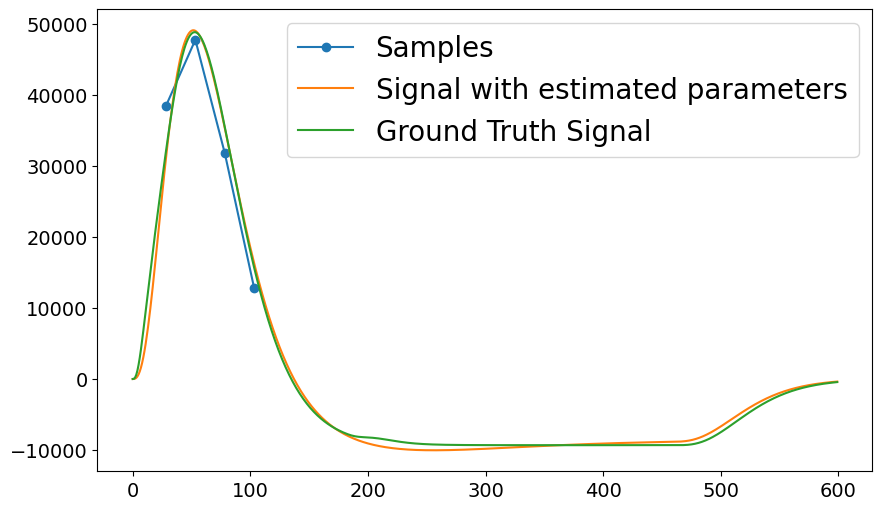

In [404]:
plt.plot([df["delay_sampling"][0] + 25,
          df["delay_sampling"][0] + 50,
          df["delay_sampling"][0] + 75,
          df["delay_sampling"][0] + 100], samples, marker='o', label="Samples")

ETrue_est = np.array([best["E"]*cellFunction(t*46.74/best["tau"]) for t in range(600)])
XT_est = np.array([best["E_x"]*XTalk(t*32.16/best["tau_x"]) for t in range(600)])
signal_est = ETrue_est + XT_est

ETrue_gt = np.array([df["E"][signal_index]*cellFunction(t*46.74/df["tau"][signal_index]) for t in range(600)])
XT_gt = np.array([df["E_x"][signal_index]*XTalk(t*32.16/df["tau_x"][signal_index]) for t in range(600)])
signal_gt = ETrue_gt + XT_gt

plt.plot(range(600), signal_est, label="Signal with estimated parameters")
plt.plot(range(600), signal_gt, label="Ground Truth Signal")
plt.legend()
plt.show()